<a href="https://colab.research.google.com/github/RENISA-GRACELIN/Online_Internship_Projects/blob/main/ML_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Attention, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns


# **Define Path**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

train_dir = '/content/drive/MyDrive/DR/Train'
test_dir = '/content/drive/MyDrive/DR/Test'
valid_dir = '/content/drive/MyDrive/DR/Valid'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Image Augmentation**

In [3]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    brightness_range=[0.2, 1.0]
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_set = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1750 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


# **Pre-Trained Building**

In [5]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# **Feature Extraction**

In [6]:
feature_extractor = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.output
)

train_features = feature_extractor.predict(train_set)
valid_features = feature_extractor.predict(valid_set)
test_features = feature_extractor.predict(test_set)

# Flatten extracted features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
valid_features_flat = valid_features.reshape(valid_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Get the labels
train_labels = train_set.classes
valid_labels = valid_set.classes
test_labels = test_set.classes

8/8 [==============================] - 22s 3s/step


# **ML Classifier**

In [7]:
# SVM
svm_classifier = SVC()
svm_classifier.fit(train_features_flat, train_labels)
svm_predictions = svm_classifier.predict(test_features_flat)

# KNN
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(train_features_flat, train_labels)
knn_predictions = knn_classifier.predict(test_features_flat)

# **Define Attention Mechanism**

In [8]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.squeeze(tf.tanh(tf.matmul(x, self.W) + self.b), axis=-1)
        at = tf.nn.softmax(et)
        at = tf.expand_dims(at, axis=-1)
        output = x * at
        output = tf.reduce_sum(output, axis=1)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


# **Attention Layer**

In [9]:
attention_model = Sequential()
attention_model.add(base_model)
attention_model.add(AttentionLayer())
attention_model.add(Flatten())
attention_model.add(Dense(512, activation='relu'))
attention_model.add(Dropout(0.5))
attention_model.add(Dense(5, activation='softmax'))

# **Optimizer and Compiler**

In [10]:
optimizer = Adam(lr=0.0001)
attention_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# **About the model**

In [11]:
attention_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 attention_layer (Attention  (None, 7, 1280)           1287      
 Layer)                                                          
                                                                 
 flatten (Flatten)           (None, 8960)              0         
                                                                 
 dense (Dense)               (None, 512)               4588032   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2

# **Train the model**

In [13]:
history = attention_model.fit(train_set, validation_data=valid_set, epochs=10, batch_size=8)


Epoch 1/10
55/55 [==============================] - 654s 11s/step - loss: 1.3766 - accuracy: 0.4743 - val_loss: 11.3088 - val_accuracy: 0.2000
Epoch 2/10
55/55 [==============================] - 612s 11s/step - loss: 0.8771 - accuracy: 0.6269 - val_loss: 6.1481 - val_accuracy: 0.2000
Epoch 3/10
55/55 [==============================] - 618s 11s/step - loss: 0.7171 - accuracy: 0.6903 - val_loss: 8.1877 - val_accuracy: 0.2000
Epoch 4/10
55/55 [==============================] - 615s 11s/step - loss: 0.7363 - accuracy: 0.6977 - val_loss: 3.6174 - val_accuracy: 0.2000
Epoch 5/10
55/55 [==============================] - 580s 11s/step - loss: 0.6474 - accuracy: 0.7360 - val_loss: 8.9321 - val_accuracy: 0.2000
Epoch 6/10
55/55 [==============================] - 575s 10s/step - loss: 0.6830 - accuracy: 0.7297 - val_loss: 24.7215 - val_accuracy: 0.2000
Epoch 7/10
55/55 [==============================] - 590s 11s/step - loss: 0.5464 - accuracy: 0.7703 - val_loss: 9.1258 - val_accuracy: 0.2000
Epoc

# **Save the model**

In [15]:
attention_model.save("newmodel_ml.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Performance metrics**

In [16]:
y_pred = attention_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

8/8 [==============================] - 20s 2s/step


In [17]:
# Compute confusion matrix
cm = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[ 0  0  0 50  0]
 [ 0  0  0 50  0]
 [ 0  0  0 50  0]
 [ 0  0  0 50  0]
 [ 0  0  0 50  0]]


Text(0.5, 1.0, 'Confusion Matrix')

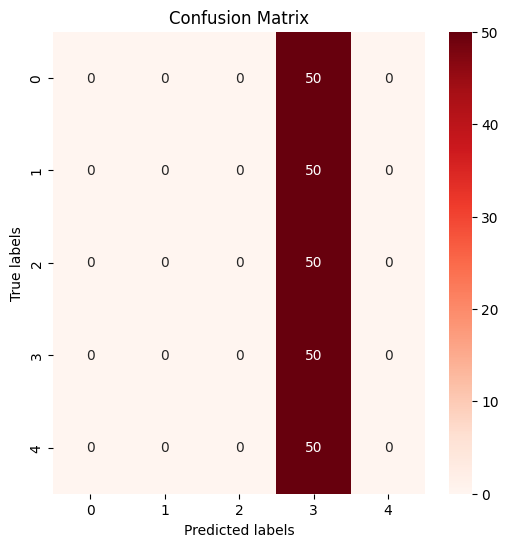

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap="Reds", fmt="d",
            xticklabels=train_set.class_indices.keys(),
            yticklabels=train_set.class_indices.keys(), ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [25]:
# Compute classification report
class_name = train_set.class_indices
print(class_name)
report = classification_report(test_set.classes, y_pred, target_names=class_name)
print('Classification Report:')
print(report)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.20      1.00      0.33        50
           4       0.00      0.00      0.00        50

    accuracy                           0.20       250
   macro avg       0.04      0.20      0.07       250
weighted avg       0.04      0.20      0.07       250



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
precision = precision_score(test_set.classes, y_pred, average='macro')
recall = recall_score(test_set.classes, y_pred, average='macro')
accuracy = accuracy_score(test_set.classes, y_pred)
f1 = f1_score(test_set.classes, y_pred, average='macro')
print('Precision:', precision)
print('Recall:', recall)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

Precision: 0.04
Recall: 0.2
Accuracy: 0.2
F1 Score: 0.06666666666666668


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# SVM and KNN Classification Report
print('SVM Classification Report:')
print(classification_report(test_labels, svm_predictions))

print('KNN Classification Report:')
print(classification_report(test_labels, knn_predictions))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.20      1.00      0.33        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50

    accuracy                           0.20       250
   macro avg       0.04      0.20      0.07       250
weighted avg       0.04      0.20      0.07       250

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.20      1.00      0.33        50
           4       0.00      0.00      0.00        50

    accuracy                           0.20       250
   macro avg       0.04      0.20      0.07       250
weighted avg       0.04

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif